<a href="https://colab.research.google.com/github/wisdomscode/Deep-Learning-using-PyTorch/blob/main/AI_Lab_3_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We will build our very first neural network model. We'll use this model to classify if a wildlife camera image shows a hog or not.

**Objectives:**

* Convert images from grayscale to RGB
* Resizes images
* Create a transformation pipeline to standardize images for training
* Build and train a simple neural network model in PyTorch
* Save our trained neural network to disk

**New Terms:**

* Activation function
* Automatic differentiation
* Backpropagation
* Binary classification
* Cross-entropy
* Epoch
* Layers
* Logits
* Optimizer

In [3]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

In [2]:
!pip install torchinfo

To test our imports

In [4]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: linux
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
---
CV2 version :  4.11.0
matplotlib version :  3.10.0
numpy version :  1.26.4
torch version :  2.5.1+cu124
torchinfo version :  1.8.0
torchvision version :  0.20.1+cu124
PIL version :  11.1.0
scikit-learn version:  1.6.1
tqdm version:  4.67.1


To check if GPUs are available

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


# Exploring Data

Our goal is to build a model that can identify wildlife in photos taken by automated surveillance systems, also called "camera traps."

It assumed we have the data in our data file.

We have our train data folder in
data_p1/data_binary/train

inside of which we have blank and hog folders

Task 1.3.1: Assign train_dir the path to the training data.

In [ ]:
data_dir = os.path.join("data_p1", "data_binary")
train_dir = os.path.join(data_dir, "train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

List the items inside the train folder, we use listdir

In [ ]:
labels = os.listdir(train_dir)
labels

# output
['hog', 'blank']

Count Items in a hog folder

In [ ]:
hog_path = os.path.join(train_dir, "hog")
hog_images = os.listdir(hog_path)
print("length of hog images: ", len(hog_images))

# output
length of hog images:  978



Task 1.3.2: Determine the number of blank images in the training data and assign the result to blank_images.

In [ ]:
blank_path = os.path.join(train_dir, "blank")
blank_images = os.listdir(blank_path)
print("length of blank images: ", len(blank_images))

# outout
length of blank images:  2213



Create a Path to individual image in the folders

Task 1.3.3: Display the path of one image of the blank class.

In [ ]:
# get name of first image in the hog folder
hog_image_name = hog_images[0]
print(hog_image_name)

# get the path
hog_image_path = os.path.join(hog_path, hog_image_name)
print(hog_image_path)

# get name of first image in the blank folder
blank_image_name = blank_images[1]
print(blank_image_name)

# get the path
blank_image_path = os.path.join(blank_path, blank_image_name)
print(blank_image_path)

# outputs
ZJ012491.jpg
data_p1/data_binary/train/hog/ZJ012491.jpg
ZJ001885.jpg
data_p1/data_binary/train/blank/ZJ001885.jpg

**Mode** (Color and Gray) and **Size** of Image

Recall how the mode describes the pixel data of the images. In the past, we've seen both grayscale and red green blue (RGB). It's also important to check out the size of the images

Task 1.3.4: Print out the mode and size for the blank image sample.

In [ ]:
hog_img_pil = Image.open(hog_image_path)
print("Hog image: ", hog_img_pil.mode, hog_img_pil.size)

blank_img_pil = Image.open(blank_image_path)
print("Blank image: ", blank_img_pil.mode, blank_img_pil.size)

#output
Hog image:  L (360, 240)
Blank image:  RGB (640, 360)

To see the actual image

In [ ]:
hog_img_pil

In [ ]:
blank_img_pil

**Preparing Our Data**

We need to make sure all of our images are in the same mode. We want to make sure they're in RGB format. If not, we'll need to convert them. In fact, our sample hog image was in grayscale, denoted by the "L" for its mode value. We'll create a custom transformer that will convert an image to RGB mode if it's not.

Function to Convert image to RGB

In [ ]:
class ConvertToRGB:
  def __call__(self, img):
    if img.mode != "RGB":
      img = img.convert("RGB")
    return img

We're using the special method __call__ which makes it a callable class. In other words, it acts like a function. We need this method to use ConvertToRGB in our preprocessing pipeline.

Remember how we previously used utilities from the torchvision package. We'll use transforms.Compose to create a "pipeline" of preprocessing sets. The steps defined (in order) will be:
* Convert image (if needed) to RGB
* Resize the image
* Convert the images to PyTorch tensors

Afterwards, we'll load the data and apply the transformation pipeline.

**Task 1.3.5:** Define transformation Pipeline for Image

In [ ]:
# Define transformation to apply to the images
transform = transforms.Compose(
    [
        ConvertToRGB(),  # Convert images to RGB format if not already
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor() # Convert images to tensors

    ]
)

print(type(transform))
print(transform)

# output
<class 'torchvision.transforms.transforms.Compose'>
Compose(
    <__main__.ConvertToRGB object at 0x78adb9991310>
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Now we'll load the data by using datasets from the torchvision package.

In [ ]:
# Load the dataset using `ImageFolder`
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

# output
Dataset ImageFolder
    Number of datapoints: 3191
    Root location: data_p1/data_binary/train
    StandardTransform
Transform: Compose(
               <__main__.ConvertToRGB object at 0x78adb9991310>
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

The dataset object has the attribute .classes which returns a list of distinct classes.

In [ ]:
dataset.classes

#output
['blank', 'hog']



**Prove Binary Values**




Note: The .imgs attribute is a list of tuples of path to image and label. The label value will be a number. Since we're doing binary classification, there will only be two distinct numbers. Those numbers are 0 and 1.

**Task 1.3.6:** Prove that the only distinct values of im are 0 and 1. You should use a set data structure

In [ ]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print()
print(distinct_classes)

# output
('data_p1/data_binary/train/blank/ZJ000013.jpg', 0)

{0, 1}

As we're doing supervised machine learning, we need to perform a train/validation split. A validation set is used to help choose our model when training.

It's typical to use an 80/20 split (80 for training, 20 for validation). The random_split function will help us perform the split.

**To Split data into train/validation**

In [ ]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

**Task 1.3.7:** Now let's inspect the sizes of the splits.

In [ ]:
print(f"Length of training set: {len(train_dataset)}")


In [ ]:
print(f"Length of validation set: {len(val_dataset)}")


**Data Visualization**

Lets Explore the data. We'll create a visualization to show the breakdown of the two classes. The function below goes through the dataset and counts how many images are in each class.

In [ ]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset)) # counts the items, tqdm() shows a progess bar
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()}) # this ensures that name either blank or hog is return instead of 0 or 1

In [ ]:
train_counts = class_counts(train_dataset)
train_counts

# output
100%
 2553/2553 [00:11<00:00, 206.64it/s]
blank    1749
hog       804
dtype: int64

**Make a Bar Chart of Train_count**

The pandas built-in plotting can make a nice visualization out of it.

In [ ]:
train_counts.sort_values().plot(kind="bar");

Do same for validation data set

In [ ]:
val_counts = class_counts(val_dataset)
val_counts

Make a Bar Chart for Validation Data

In [ ]:
# Make a bar chart from the function output
val_counts.sort_values().plot(kind="bar")

**DataLoader**

The next step is to create DataLoader objects. These objects are iterables that work well with PyTorch when training. We'll use a batch size of 32, which is standard for neural networks. The main difference between the DataLoader for training and validation is that shuffling is turned on for training. Turning on shuffling for the training data randomly rearranges the data after we have gone over all of the batches. Shuffling prevents any particular batch of data from having too much influence on the training.

Task 1.3.9: Create the train loader, make shuffling on, so that is shuffled each time a batch is taken

In [ ]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)


Task 1.3.9: Create the validation loader. Make sure to set shuffling to be off.

In [ ]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(type(val_loader))

Now with the DataLoader objects, we'll show they're iterables by using iter and next. There's no need to do this all the time, we're just exploring how PyTorch will make use of the DataLoader objects. iter returns an iterator. This iterator will give us the next value in an iteration.

We'll get one sample batch of images and labels and make sure the dimensions match what we expect. One batch of images should be a 4D tensor with dimension [32, 3, 224, 224]. This is because we set the batch to 32, we have RGB images that have 3 color channels, and our images have height 224 and width 224.

One batch of labels should be a one dimensional tensor of length 32.

Task 1.3.10: Print the shape of a batch of images and the shape of a batch of labels.

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

# output
Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


Let's examine the labels tensor to make sure it's nothing but ones and zeros.

In [ ]:
labels

#output
tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 1])

In [ ]:
# the length of the batch
len(labels)

# Building a Shallow Neural Network



We're now ready to create our first neural network model. The model will be a shallow fully connected network. It'll not have too many layers, in fact, it'll have four. Here's the architecture:

* The input layer
* Two hidden layers
* The output layer
The image below is an example of our architecture. Note, the image shows fewer neurons than what we'll build as it's hard to visualize a model with many neurons. The important part is that we have an input layer, two hidden layers, and two nodes for the output layer.


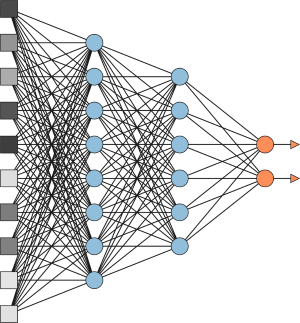


Our input data are images. Each image is a 3D tensor. The shape is 3 x 224 x 224. But there's one problem. This neural network can't accept images in two dimensions. We need to first ***flatten*** the image. As you can imagine, we lose some information when we flatten the image. In a later lesson, we'll see a better neural network architecture at preserving the spatial relational data that is lost when flattening.

Let's walk through the flattening process with images. Convenient for us, images is already a PyTorch tensor. In the previous task, we determined that its shape is **32 x 3 x 224 x 224**.

The first dimension represents the number of images we have in the batch. If we flatten our images, we should get a tensor of 32 x 150528. Why 150528? It's the product of **3 x 224 x 224**.

Each image, instead of being three dimensional, will now just have one dimension.

**Flattening the Image**

**Task 1.3.11:** Flatten the image and print out the resulting shape of the tensor. Use the nn.Flatten class to flatten.

In [ ]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

# Print the shape of the flattened tensor
print(f"Shape of flattened tensor: {tensor_flatten.shape}")

# output
Shape of flattened tensor: torch.Size([32, 150528])

Flattening the images is the first step or layer of our model. However, it'll be tedious if we have to manually apply all the layers of our network. Instead we'll use the nn.Sequential class from PyTorch. It offers an easy way to define the architecture. As the name suggests, this class takes a sequence of layers and runs the data through them in order.

In [ ]:
# Image size from our transformer
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),  # 1 inner layer
    nn.ReLU(),
    nn.Linear(512, 128),      # 2 inner layer
    nn.ReLU(),
)

# we do not have the out layer yet

print("model type:", type(model))
print("model structure:")
print(model)

# output
model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)

Now let's add the last layer needed for the model. That layer is a nn.Linear with an input size of 128 and an output size of 2. Additional layers can be added/appended to a model with model.append.

**Task 1.3.12:** Create the output layer. The last line of the cell below will append it to the model.

In [ ]:
output_layer = nn.Linear(128, 2) # No of neurons in the last layer, expected no of output
model.append(output_layer)

print(model)

# output
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

We can see three different types of layers being used:

* nn.Flatten flattens the three-dimensional input tensors to the one-dimensional tensors that the next layers expect.
* nn.Linear is a standard dense, or fully-connected, layer. It takes two arguments, the number of inputs coming into this layer and the number of outputs produced by this layer.
* nn.ReLU performs the rectified linear unit activation. Activation functions are necessary for neural networks to work, and ReLU is a popular choice.

The last nn.Linear is our output layer. It must have 128 inputs, to match the output of the preceding layer, and it must have 2 outputs to match the two classes. Note that there's no activation function applied after the output layer. This means that the outputs of this layer are the logits. Later on, these logits will be the input to a normalization function, called softmax in this case, that will turn the logits into probabilities.